In [1]:
import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.0.0


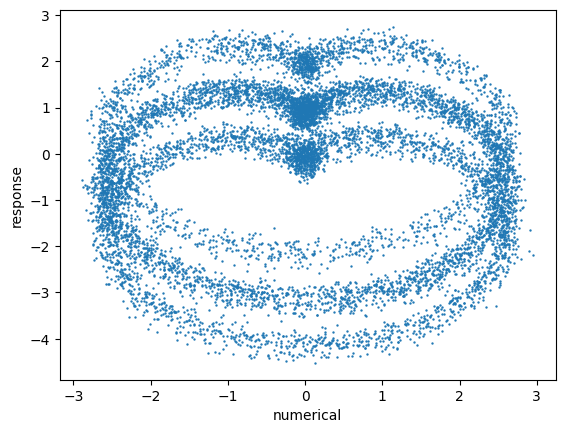

In [2]:
# build modified cardiac data: https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal
n = 10000
time = np.random.uniform(low=-np.pi, high=np.pi, size=n)
radius = 2 * (1 - np.cos(time))

# build model predictors
hour = np.random.uniform(low=0, high=24, size=n)
x = radius * np.sin(time) + np.random.normal(loc=0., scale=0.1, size=n)
noise = np.random.normal(loc=0., scale=10, size=n)
categorical = np.random.choice(['A','B','C'], size=n, p=[0.2, 0.5, 0.3])

# build response
offset = (categorical == 'A').astype(float) - (categorical == 'C').astype(float)
y = radius * np.cos(time) + np.random.normal(loc=0., scale=0.1, size=n) + np.cos(hour / 24.0) + offset

# store in a dataframe
data = pd.DataFrame({
    'numerical' : x,
    'categorical' : categorical,
    'periodic' : hour,
    'noise' : noise,
    'response' : y,
})

# the joint distribution conditional on only x is a mess!
plt.scatter(data.numerical, data.response, s=0.5);
plt.xlabel('numerical');
plt.ylabel('response');

In [3]:
# split the data
training_data, validation_data, test_data = qa.train_val_test_split(data)

# create the driver, this will generate the tensorflow dataset and feed data
# also set the Noam optimizer
driver = qa.Driver(training_data, validation_data, test_data, qa.optimizers.Noam())

# what does our response look like?
head = qa.heads.GaussianMixture()

# all the predictors for the model
predictors = [
    qa.predictors.NumericalPredictor('numerical'),
    qa.predictors.CategoricalPredictor('categorical'),
    qa.predictors.PeriodicPredictor('periodic', 24.0),
    qa.predictors.NumericalPredictor('noise', drop=qa.tuning.HyperBoolean()),
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.ResNet('response', head, predictors, driver)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train()

Trial 234 Complete [00h 01m 07s]
val_log_prob: 0.8306720852851868

Best val_log_prob So Far: 0.17132708430290222
Total elapsed time: 01h 48m 19s

Search: Running Trial #235

Value             |Best Value So Far |Hyperparameter
128               |512               |ResNet/model_dim
6                 |2                 |ResNet/blocks
gelu              |relu              |ResNet/activation
0.4               |0                 |ResNet/dropout
2                 |3                 |ResNet/projection_scale
0                 |0.1               |categorical/dropout
False             |True              |categorical/use_one_hot
32                |None              |categorical/embed_dim
0.1               |None              |categorical/embed_l2_regularizer
False             |True              |noise/drop
True              |True              |GaussianMixture/non_linear_projection
4                 |1                 |GaussianMixture/projection_scale
relu              |gelu              |GaussianMi


KeyboardInterrupt



In [ ]:
# evaluate the model on test data
model.evaluate()

In [ ]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

In [ ]:
# what is the range we want to sample in our plot
response_range = np.linspace(-4, 4, 300)

# get the predicted joint distribution
density = np.mean(model.predict_distribution(test_data, response_range), axis=0)

# plot the joint distribution
plt.plot(response_range, density);
plt.xlabel('response');
plt.ylabel('density');